<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/main/Code/Drafts/Baseline_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Parlementarian Sentiment Analysis: Sequence Classification</font></strong></center></h1>
<h3><center><font color="green"><strong>Baseline Model</strong></font></center></h3>

<center>
April 2022, Houri & Sansu
</center>

## <font color="chillipepper">Modules and packages</font>

In [ ]:
!pip install datasets

     |████████████████████████████████| 325 kB 6.1 MB/s 
     |████████████████████████████████| 136 kB 37.5 MB/s 
     |████████████████████████████████| 1.1 MB 29.3 MB/s 
     |████████████████████████████████| 212 kB 36.0 MB/s 
     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 127 kB 22.7 MB/s 
     |████████████████████████████████| 271 kB 41.8 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 30.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import torch
import numpy as np
import datasets
from datasets import load_dataset
from tqdm import tqdm
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from collections import Counter
import torchtext
from sklearn.model_selection import train_test_split
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F

## <font color="chillipepper">Data</font>

**Import the annotated data**

In [ ]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv', index_col =0)

In [ ]:
df = df.rename(columns={'Label': 'label'})

**Prepare the data for machine learning tasks**

In [ ]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
# dataset = ds.dataset(pa.Table.from_pandas(train).to_batches())

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train))

## <font color="chillipepper">Pre-trained Embeddings</font>

**First NLP tasks**

In [ ]:
# Run only once: several min long
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='fr')

.vector_cache/wiki.fr.vec: 3.03GB [01:30, 33.4MB/s]                            
100%|██████████| 1152449/1152449 [02:32<00:00, 7573.65it/s]


In [ ]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([1152450, 300])

## <font color="chillipepper">Tokenization</font>

In [ ]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()

In [ ]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  res['label'] = entries['label']
  return res

train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(train_dataset['label'])

[1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 

In [ ]:
# dataset = ds.dataset(pa.Table.from_pandas(test).to_batches())

### convert to Huggingface dataset
test_dataset = Dataset(pa.Table.from_pandas(test))

# tokenize
test_dataset = test_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(test_dataset['label'])

[2, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]


In [ ]:
# dataset = ds.dataset(pa.Table.from_pandas(test).to_batches())

### convert to Huggingface dataset
val_dataset = Dataset(pa.Table.from_pandas(validate))

# tokenize
val_dataset = val_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(val_dataset['label'])

[2, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0]


## <font color="chillipepper">Building of the model</font>

In [ ]:
# Create the Dataset class

from torch.utils.data import Dataset
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

In [ ]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(train_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(test_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader  = DataLoader(TweetDataset(val_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
# Define the model to classify tweets

class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 600
})

In [ ]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 labels
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [ ]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**We'll need a GPU**

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  Tesla K80


TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**Train the model**

In [ ]:
# Training loop

def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
# Start training

import torch.optim as optim

def run_epochs(model, args):

  # args['device'] =device
  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 80, 'lr': 0.001, 'device': 'gpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cuda
device set to cuda


Epoch 0::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0/80 : Training : (loss 1.0980352428224351) (acc 0.3645833333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.096445083618164) (acc 0.4322916666666667)


Epoch 1::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/80 : Training : (loss 1.0958134995566473) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0941306749979656) (acc 0.40625)


Epoch 2::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/80 : Training : (loss 1.0921228064431086) (acc 0.4184027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.089315414428711) (acc 0.4114583333333333)


Epoch 3::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/80 : Training : (loss 1.0876743131213717) (acc 0.4097222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.084469477335612) (acc 0.4166666666666667)


Epoch 4::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/80 : Training : (loss 1.0798148446612887) (acc 0.4305555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0777105887730916) (acc 0.4114583333333333)


Epoch 5::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/80 : Training : (loss 1.0746495591269598) (acc 0.4184027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0676734447479248) (acc 0.4166666666666667)


Epoch 6::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/80 : Training : (loss 1.0676188468933105) (acc 0.4079861111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.070387363433838) (acc 0.4010416666666667)


Epoch 7::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/80 : Training : (loss 1.0638562705781724) (acc 0.4114583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0687787135442097) (acc 0.4270833333333333)


Epoch 8::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/80 : Training : (loss 1.0601602792739868) (acc 0.4270833333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0643446842829387) (acc 0.4270833333333333)


Epoch 9::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/80 : Training : (loss 1.0569335222244263) (acc 0.4444444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0799250205357869) (acc 0.390625)


Epoch 10::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/80 : Training : (loss 1.0524225897259183) (acc 0.4270833333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0653286377588909) (acc 0.4114583333333333)


Epoch 11::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/80 : Training : (loss 1.0466577079561021) (acc 0.4375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0701062281926472) (acc 0.4166666666666667)


Epoch 12::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/80 : Training : (loss 1.0495608515209622) (acc 0.4444444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.061045527458191) (acc 0.40625)


Epoch 13::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/80 : Training : (loss 1.047916226916843) (acc 0.46875)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.070318341255188) (acc 0.4166666666666667)


Epoch 14::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/80 : Training : (loss 1.0434627665413752) (acc 0.4357638888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0746238629023235) (acc 0.40625)


Epoch 15::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/80 : Training : (loss 1.0406205256779988) (acc 0.4878472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.075027346611023) (acc 0.4010416666666667)


Epoch 16::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/80 : Training : (loss 1.0406985150443182) (acc 0.4305555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0614659786224365) (acc 0.4114583333333333)


Epoch 17::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/80 : Training : (loss 1.0371794568167791) (acc 0.4618055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0800540447235107) (acc 0.40625)


Epoch 18::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/80 : Training : (loss 1.0364293654759724) (acc 0.4635416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0992988745371501) (acc 0.40625)


Epoch 19::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/80 : Training : (loss 1.0377883116404216) (acc 0.4618055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.085770567258199) (acc 0.4010416666666667)


Epoch 20::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/80 : Training : (loss 1.035227484173245) (acc 0.453125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0733195145924885) (acc 0.3958333333333333)


Epoch 21::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/80 : Training : (loss 1.0326165954271953) (acc 0.4583333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0639776786168416) (acc 0.40625)


Epoch 22::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/80 : Training : (loss 1.0291273196538289) (acc 0.4913194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0778370300928752) (acc 0.4010416666666667)


Epoch 23::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/80 : Training : (loss 1.0320899089177449) (acc 0.5)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.065364400545756) (acc 0.3958333333333333)


Epoch 24::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/80 : Training : (loss 1.029733935991923) (acc 0.46875)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0811898708343506) (acc 0.390625)


Epoch 25::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/80 : Training : (loss 1.031900233692593) (acc 0.5052083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0791609287261963) (acc 0.3958333333333333)


Epoch 26::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/80 : Training : (loss 1.0239509211646185) (acc 0.5208333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.056227723757426) (acc 0.4166666666666667)


Epoch 27::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/80 : Training : (loss 1.0244864225387573) (acc 0.5225694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0753437678019206) (acc 0.3854166666666667)


Epoch 28::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/80 : Training : (loss 1.0252112680011325) (acc 0.4722222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0867829322814941) (acc 0.390625)


Epoch 29::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/80 : Training : (loss 1.0200607246822782) (acc 0.5451388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0661508639653523) (acc 0.3802083333333333)


Epoch 30::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/80 : Training : (loss 1.017177614900801) (acc 0.5104166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0778232018152873) (acc 0.4114583333333333)


Epoch 31::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/80 : Training : (loss 1.020878427558475) (acc 0.5104166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.096220890680949) (acc 0.359375)


Epoch 32::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/80 : Training : (loss 1.023279435104794) (acc 0.5347222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.057439645131429) (acc 0.421875)


Epoch 33::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/80 : Training : (loss 1.0183547867669) (acc 0.5173611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0594866275787354) (acc 0.4270833333333333)


Epoch 34::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/80 : Training : (loss 1.0154240330060322) (acc 0.5416666666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0976946353912354) (acc 0.3385416666666667)


Epoch 35::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/80 : Training : (loss 1.0157705081833734) (acc 0.5416666666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0656351645787556) (acc 0.390625)


Epoch 36::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/80 : Training : (loss 1.0112420982784696) (acc 0.5243055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0680065552393596) (acc 0.3958333333333333)


Epoch 37::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/80 : Training : (loss 1.0122862060864766) (acc 0.5451388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0664805173873901) (acc 0.40625)


Epoch 38::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/80 : Training : (loss 1.0079771280288696) (acc 0.5607638888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0819199085235596) (acc 0.3958333333333333)


Epoch 39::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/80 : Training : (loss 1.006361722946167) (acc 0.5677083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074015776316325) (acc 0.421875)


Epoch 40::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/80 : Training : (loss 1.0052878790431552) (acc 0.5364583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0804287592569988) (acc 0.375)


Epoch 41::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/80 : Training : (loss 1.0009055932362874) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0781337817509968) (acc 0.40625)


Epoch 42::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/80 : Training : (loss 0.9986281659868028) (acc 0.5538194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0725065469741821) (acc 0.4114583333333333)


Epoch 43::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/80 : Training : (loss 0.9975050886472067) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.081707239151001) (acc 0.4010416666666667)


Epoch 44::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/80 : Training : (loss 0.9966931011941698) (acc 0.5763888888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0789915323257446) (acc 0.375)


Epoch 45::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/80 : Training : (loss 1.0000062849786546) (acc 0.5677083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.085284431775411) (acc 0.3958333333333333)


Epoch 46::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/80 : Training : (loss 0.9962095552020602) (acc 0.5381944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0659946203231812) (acc 0.4479166666666667)


Epoch 47::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/80 : Training : (loss 0.997969024711185) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0669421752293904) (acc 0.4427083333333333)


Epoch 48::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/80 : Training : (loss 0.9904065397050645) (acc 0.5503472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0749270915985107) (acc 0.4322916666666667)


Epoch 49::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/80 : Training : (loss 0.9884726140234206) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074951450030009) (acc 0.4375)


Epoch 50::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/80 : Training : (loss 0.9906646675533719) (acc 0.5711805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0846034685770671) (acc 0.3541666666666667)


Epoch 51::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/80 : Training : (loss 0.9895276294814216) (acc 0.59375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0663450956344604) (acc 0.4166666666666667)


Epoch 52::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/80 : Training : (loss 0.98863775200314) (acc 0.5711805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.06492813428243) (acc 0.3958333333333333)


Epoch 53::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/80 : Training : (loss 0.9822852479086982) (acc 0.5920138888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0874271392822266) (acc 0.3697916666666667)


Epoch 54::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/80 : Training : (loss 0.985988610320621) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.071549614270528) (acc 0.40625)


Epoch 55::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/80 : Training : (loss 0.9815138048595853) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0818884372711182) (acc 0.40625)


Epoch 56::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/80 : Training : (loss 0.9822880228360494) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0665141741434734) (acc 0.453125)


Epoch 57::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/80 : Training : (loss 0.9784080584843954) (acc 0.5972222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0590160290400188) (acc 0.4427083333333333)


Epoch 58::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/80 : Training : (loss 0.9837465749846565) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0761820872624714) (acc 0.40625)


Epoch 59::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/80 : Training : (loss 0.9729423655403985) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.070359468460083) (acc 0.4010416666666667)


Epoch 60::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/80 : Training : (loss 0.9721464316050211) (acc 0.5972222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0785826047261555) (acc 0.40625)


Epoch 61::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/80 : Training : (loss 0.9719278812408447) (acc 0.6006944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0848334232966106) (acc 0.375)


Epoch 62::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/80 : Training : (loss 0.9738904303974576) (acc 0.5850694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0886756976445515) (acc 0.390625)


Epoch 63::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/80 : Training : (loss 0.9756348331769308) (acc 0.5677083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0846219062805176) (acc 0.3645833333333333)


Epoch 64::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/80 : Training : (loss 0.9714463816748725) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0577661991119385) (acc 0.4010416666666667)


Epoch 65::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/80 : Training : (loss 0.9639812641673617) (acc 0.6024305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0735217730204265) (acc 0.4270833333333333)


Epoch 66::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/80 : Training : (loss 0.9653578996658325) (acc 0.6076388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0699976682662964) (acc 0.4635416666666667)


Epoch 67::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/80 : Training : (loss 0.9647075997458564) (acc 0.6076388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.067947546641032) (acc 0.4427083333333333)


Epoch 68::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/80 : Training : (loss 0.9641821649339464) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0793520609537761) (acc 0.4114583333333333)


Epoch 69::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/80 : Training : (loss 0.9618040919303894) (acc 0.6059027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0738900502522786) (acc 0.40625)


Epoch 70::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/80 : Training : (loss 0.9607509771982828) (acc 0.6302083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.097551425298055) (acc 0.3854166666666667)


Epoch 71::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/80 : Training : (loss 0.9638390673531426) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.079440712928772) (acc 0.4114583333333333)


Epoch 72::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/80 : Training : (loss 0.9573447042041354) (acc 0.5972222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0724031925201416) (acc 0.4322916666666667)


Epoch 73::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/80 : Training : (loss 0.9553093181716071) (acc 0.6006944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0624888340632122) (acc 0.46875)


Epoch 74::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/80 : Training : (loss 0.9559518562422858) (acc 0.6163194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074512243270874) (acc 0.4322916666666667)


Epoch 75::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/80 : Training : (loss 0.9569609098964267) (acc 0.6006944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0686388810475667) (acc 0.4583333333333333)


Epoch 76::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/80 : Training : (loss 0.9544789526197646) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0616601705551147) (acc 0.46875)


Epoch 77::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/80 : Training : (loss 0.9452999432881674) (acc 0.6059027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0678903659184773) (acc 0.4427083333333333)


Epoch 78::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/80 : Training : (loss 0.9542638195885552) (acc 0.6024305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0636803110440571) (acc 0.453125)


Epoch 79::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/80 : Training : (loss 0.9465001556608412) (acc 0.6076388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0685652097066243) (acc 0.4739583333333333)


**Evaluate the model**

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/3 [00:00<?, ?it/s]

test : (loss 0.990537166595459) (acc 0.5520833333333334)


In [ ]:
set(preds)

{0, 1, 2}

In [ ]:
names = [0,1,2]

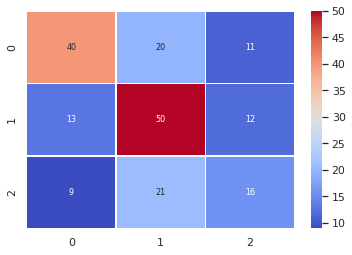

In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [ ]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'Tweets_sample_confinement.csv', index_col =0)

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
df_conf = Dataset(pa.Table.from_pandas(df))

  0%|          | 0/33 [00:00<?, ?ba/s]

KeyError: ignored

In [ ]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  #res['label'] = entries['label']
  return res

train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

In [ ]:
df_conf

In [ ]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
df_conf_loader = DataLoader(TweetDataset(df_conf, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
# Create the Dataset class

from torch.utils.data import Dataset
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          #"label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

In [ ]:
sizes = next(iter(df_conf_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

KeyError: ignored